In [1]:
# necessary imports

import os
import re

# import gseapy as gp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import seaborn as sns

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu

from plotnine import *

# set arial as the publication font
from plotnine.options import set_option
set_option('base_family',  'Arial')

# is used in many cells later
types_data = pd.read_csv("../data/misc/types_data.csv", index_col=0)
types = set(types_data.type)


def calculate_average(purity_df, consensus_df, metric_name):
    """
        Input: purity_df with columns as methods + optionally, 'type' as a column (drops it)
        Output: df with averaged metrics
        
        Calculates average metric for each method specified in the purity_df columns.
    """
    metric_dfs = []
    
    if 'type' in purity_df.columns:
        methods = purity_df.columns.drop(['type'])
    else:
        methods = purity_df.columns    
    
    purity_df = purity_df.join(consensus_df)
    
    for m in methods:
        
        if metric_name == 'rmse':
            metric = (np.sqrt(mean_squared_error(purity_df['purity'], purity_df[m])))
            
        if metric_name == 'correlation':
            metric = np.corrcoef(purity_df['purity'], purity_df[m])[0][1]
        
        metric_dfs.append(pd.DataFrame(data=[metric], index=[m], columns=[metric_name]))

    metric_df = pd.concat(metric_dfs, axis=0) # concatenate separate metric dfs into one
    
    return metric_df


def calculate_average_by_type(purity_df, consensus_df, types_df, metric_name):
    """ 
        Input: dataframe of purities with at least two methods' results in columns
        Output: dataframe with metric by type
        
        Calculates similarity between methods (columns in purity df) grouped by cancer types 
    """
    frames = []
    
    methods = purity_df.columns
    try:
        purity_df = purity_df.join(types_df)
    except ValueError:
        pass
    
    for ctype in set(purity_df['type']):
        pur_by_type = purity_df[purity_df['type'] == ctype]
        df = calculate_average(pur_by_type, consensus_df, metric_name)
        df['type'] = ctype
        
        frames.append(df)
        
    df_total = pd.concat(frames, axis=0)

    return df_total

metric_name = 'rmse' # the default metric

## Figure 1: "Overview of PUREE"

Drawn manually used vector graphics

## Figure 2: "Feature selection to account for cancer type and tumor purity imbalance"

### a) Purities distribution

In [32]:
# distribution of all purities

consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
purity_df = consensus_df.copy()
types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)
types = set(types_df.type)

proportion = 0.2

n_largest = int(len(consensus_df) * proportion) # highest purities
largest_purs = consensus_df.nlargest(n_largest, 'purity')

n_smallest = int(len(consensus_df) * proportion) # lowest purities
smallest_purs = consensus_df.nsmallest(n_smallest, 'purity')

middle_purs = consensus_df.drop(largest_purs.index).drop(smallest_purs.index)

mid_p_range = (np.min(middle_purs.values), np.max(middle_purs.values))

low_lim = mid_p_range[0]
high_lim = mid_p_range[1]
purity_low = consensus_df.loc[(consensus_df < low_lim).values].index
purity_high = consensus_df.loc[(consensus_df > high_lim).values].index
purity_df['purity_range'] = '{0}-{1}'.format(np.round(low_lim, 2), np.round(high_lim, 2))
purity_df.loc[purity_low, 'purity_range'] = '0-{0}'.format(np.round(low_lim, 2))
purity_df.loc[purity_high, 'purity_range'] = '{0}-1'.format(np.round(high_lim, 2))

purity_df = purity_df.join(types_df)

purity_df_vc = (pd.DataFrame(purity_df.loc[:, ['type', 'purity_range']].value_counts())
                    .rename({0:'num_samples'}, axis=1)
                    .reset_index())

purity_df_vc['num_samples_prop'] = (purity_df_vc['num_samples'] / 
    types_data.value_counts().reindex([purity_df_vc['type']]).values)

cat_dtype = CategoricalDtype(np.sort(purity_df_vc['purity_range'].unique())[::-1], ordered=True)
purity_df_vc['purity_range'] = purity_df_vc['purity_range'].astype(cat_dtype)

x_order = purity_df.groupby('type').median().sort_values('purity').index

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/2a_box.pdf


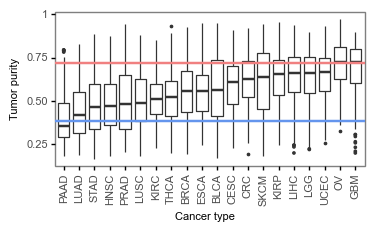

<ggplot: (8732634851027)>

In [34]:
# boxplots of purity distributions with cancer types as x axis
p = (ggplot(purity_df, aes('type', 'purity')) 
    + geom_boxplot(outlier_size=0.5)
    + geom_hline(yintercept=mid_p_range[0], colour='cornflowerblue', size=1)
    + geom_hline(yintercept=mid_p_range[1], colour='lightcoral', size=1)
     + theme_bw()
     + theme(
            panel_grid=element_blank(),
            axis_title=element_text(size=8),
            axis_text=element_text(size=8),
            axis_text_x=element_text(rotation=90),
            figure_size=(4,2))
    + labs(x='Cancer type', y='Tumor purity')
    + scale_x_discrete(limits=x_order)
)

# p.save('../plots/main/2a_box.pdf')
p

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 2 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/2a_bar.pdf


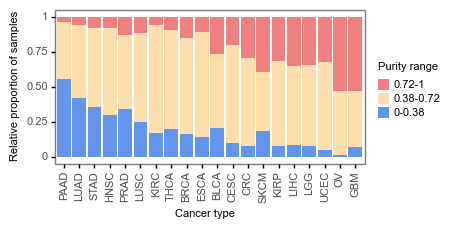

<ggplot: (8732634280391)>

In [36]:
p = (ggplot(purity_df_vc, aes('type', 'num_samples_prop', fill='purity_range')) 
    + geom_bar(position="stack", stat="identity")
     + theme_bw()
     + theme(panel_grid=element_blank(),
            axis_title=element_text(size=8),
            axis_text=element_text(size=8),
            axis_text_x=element_text(rotation=90),
            legend_text=element_text(size=8),
            legend_title=element_text(size=8),
            legend_box_margin=0.5,
            figure_size=(4,2))
    + guides(fill=guide_legend(keywidth=8, keyheight=8))
    + labs(x='Cancer type', y='Relative proportion of samples', fill='Purity range\n')
    + scale_fill_manual(values = ['lightcoral', 'navajowhite', 'cornflowerblue'])
    + scale_x_discrete(limits=x_order)
)

# p.save('../plots/main/2a_bar.pdf')
p

### b) Initial feature selection

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 2 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/2b.pdf


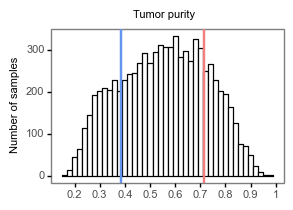

<ggplot: (8732634604713)>

In [43]:
p = (ggplot(purity_df, aes('purity')) 
    + geom_histogram(binwidth=0.02, fill='white', color='black')
    + geom_vline(xintercept=mid_p_range[0], colour='cornflowerblue', size=1)
    + geom_vline(xintercept=mid_p_range[1], colour='lightcoral', size=1)
     + theme_bw()
     + theme(panel_grid=element_blank(),
            text = element_text(size=8),
            axis_title=element_text(size=8),
            axis_text=element_text(size=8),
            figure_size=(3,2))
    + scale_x_continuous(breaks=[np.round(x,2) for x in np.arange(0,1.1,0.1)])
    + labs(x='', y='Number of samples', title='Tumor purity')
)
# p.save('../plots/main/2b.pdf')
p

### c) Secondary feature selection

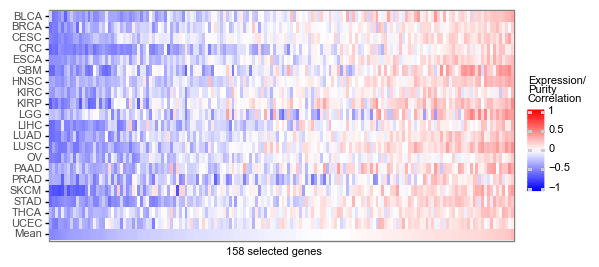

<ggplot: (8792249136378)>

In [9]:
# load pre-computed correlations
gene_corrs_ctype = pd.read_csv('../data/misc/gene_corrs_ctype.csv', index_col=0)
average_df = pd.read_csv('../data/misc/mean_corr.csv', index_col=0)

x_order = average_df.index
all_df = pd.concat([gene_corrs_ctype, average_df])

y_order = list(np.sort(list(types)))
y_order.append('Mean')
y_order = y_order[::-1]

p = (ggplot(all_df, 
        aes(x=all_df.index, y='Type'))
    + geom_tile(aes(fill='Metric'))
    + labs(x="158 selected genes", 
           y='', 
           fill='Expression/\nPurity\nCorrelation\n\n',
          )
     + theme_bw()
     + theme(panel_grid=element_blank(),
            axis_ticks_major_x = element_blank(),
            axis_text_x = element_blank(),
            axis_title=element_text(size=8),
            axis_text=element_text(size=8),
            legend_text=element_text(size=8),
            legend_title=element_text(size=8),
            legend_key_size=8,
            legend_box_margin=0.5,
            figure_size=(6,3))
    + scale_x_discrete(limits=x_order)
    + scale_y_discrete(limits=y_order)
    + scale_fill_gradient2(low='blue', high='red', limits=(-1, 1))
)

# p.save("../plots/main/2c.pdf")
p

## Figure 3: "PUREE versus cancer type-specific architectures and unseen cancer types"

### a) Cancer-specific models vs pancancer

#### Correlation

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 4.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/3a_corr.pdf


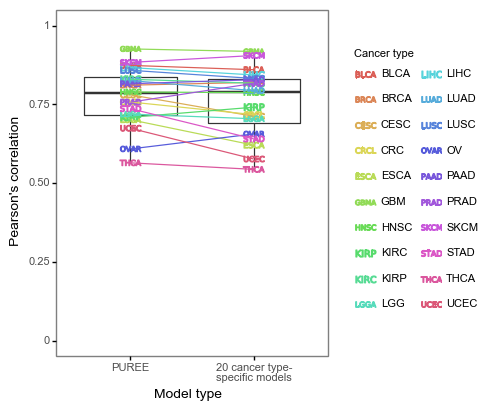

<ggplot: (8777123387534)>

In [7]:
metric_name = 'correlation'
set_type = 'test' 

model_name = 'LinearRegression'
# ctype_model_name = 'LassoCV'
feature_set = '20k_tpmf_full_linear-rt' # use all available features for cancer-specific models

## reading results for cancer-specific models 
### loading the results
purities_save_path = "../data/purities/TCGA_8K/model_tests/subtyped/"

results_ctype = dict()
consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)
types = set(types_df['type'])

for file in os.listdir(purities_save_path):
    if feature_set in file:
        res = pd.read_csv(purities_save_path + file, index_col=[0,1])
        ctype = re.split('_|\\.', file)[-2]
        results_ctype[ctype] = res
        
# cancer-specific
purity_df_ctype = pd.concat(results_ctype, axis=0).droplevel(0, axis=0).loc[set_type, :]

# pancancer
purity_df_pancan = pd.read_csv('../data/purities/TCGA_8K/model_tests/full/purities_wf_full_linear-rt_chrom_filt.csv', index_col=[0,1]).loc['test', [model_name]]

### preparing ctype results
metric_t_ctype = calculate_average_by_type(purity_df_ctype, consensus_df, types_df, metric_name=metric_name).sort_values('type')
metric_t_ctype['model_type'] = 'cancer-type-specific'

### preparing pancancer results
metric_t_pancan = calculate_average_by_type(purity_df_pancan, consensus_df, types_df, metric_name=metric_name)
metric_t_pancan = metric_t_pancan.loc[metric_t_pancan.index == model_name, :].sort_values('type')
metric_t_pancan['model_type'] = 'pancancer'


# p-value testing
from scipy import stats
_, pval_full = stats.wilcoxon(metric_t_pancan.sort_values(by='type')[metric_name], 
                              metric_t_ctype.sort_values(by='type')[metric_name])
# pval 0.1
median_delta = np.abs(metric_t_pancan.sort_values(by='type')[metric_name].median() 
              - metric_t_ctype.sort_values(by='type')[metric_name].median())
# med delt 0.006

metric_t_all = pd.concat([
                      metric_t_pancan, 
                      metric_t_ctype,
                     ])

methods = list(set(metric_t_all.model_type))

metric_t_all = metric_t_all.sort_values(by=metric_name, ascending=False)

x_order = ['cancer-type-specific', 
           'pancancer'][::-1]

shapes = (r"$\mathrm{BLCA}$", r"$\mathrm{BRCA}$", r"$\mathrm{CESC}$", r"$\mathrm{CRCL}$", r"$\mathrm{ESCA}$", 
          r"$\mathrm{GBMA}$", r"$\mathrm{HNSC}$", r"$\mathrm{KIRP}$", r"$\mathrm{KIRC}$", r"$\mathrm{LGGA}$",
          r"$\mathrm{LIHC}$", r"$\mathrm{LUAD}$", r"$\mathrm{LUSC}$", r"$\mathrm{OVAR}$",r"$\mathrm{PAAD}$", 
          r"$\mathrm{PRAD}$", r"$\mathrm{SKCM}$", r"$\mathrm{STAD}$", r"$\mathrm{THCA}$", r"$\mathrm{UCEC}$")

p = (ggplot(metric_t_all, aes(x=metric_t_all.model_type, y=metric_name))
 + geom_boxplot(outlier_shape='')
 + geom_point(aes(color=metric_t_all.type, shape=metric_t_all.type), size=8)
 + geom_line(aes(group='type', color='type'), show_legend = False
            )
 + scale_x_discrete(labels=['PUREE',
                            '20 cancer type-\nspecific models'],
                    limits=x_order)
 + theme_bw()
 + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=1,
        figure_size=(3.5, 4.5))
 + guides(shape=guide_legend(ncol=2))
 + ylim(0, 1) # for correlation
 + scale_shape_manual(name='Cancer type', values=shapes)
 + labs(y='{0}'.format("Pearson's correlation"), # for correlation
        x='Model type',
        color='Cancer type')
)

# p.save('../plots/main/3a_corr.pdf')
p

#### RMSE

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 4.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/3a_rmse.pdf
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


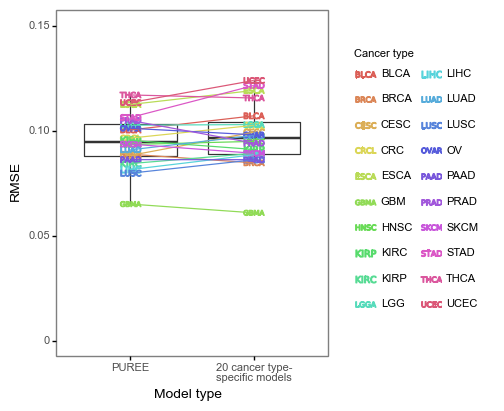

<ggplot: (8777123168772)>

In [8]:
metric_name = 'rmse' 
set_type = 'test'

model_name = 'LinearRegression'
# ctype_model_name = 'LassoCV'
feature_set = '20k_tpmf_full_linear-rt' # use all available features for cancer-specific models

## reading results for cancer-specific models 
### loading the results
purities_save_path = "../data/purities/TCGA_8K/model_tests/subtyped/"

results_ctype = dict()
consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)
types = set(types_df['type'])

for file in os.listdir(purities_save_path):
    if feature_set in file:
        res = pd.read_csv(purities_save_path + file, index_col=[0,1])
        ctype = re.split('_|\\.', file)[-2]
        results_ctype[ctype] = res
        
# cancer-specific
purity_df_ctype = pd.concat(results_ctype, axis=0).droplevel(0, axis=0).loc[set_type, :]

# pancancer
purity_df_pancan = pd.read_csv('../data/purities/TCGA_8K/model_tests/full/purities_wf_full_linear-rt_chrom_filt.csv', index_col=[0,1]).loc['test', [model_name]]

### preparing ctype results
metric_t_ctype = calculate_average_by_type(purity_df_ctype, consensus_df, types_df, metric_name=metric_name).sort_values('type')
metric_t_ctype['model_type'] = 'cancer-type-specific'

### preparing pancancer results
metric_t_pancan = calculate_average_by_type(purity_df_pancan, consensus_df, types_df, metric_name=metric_name)
metric_t_pancan = metric_t_pancan.loc[metric_t_pancan.index == model_name, :].sort_values('type')
metric_t_pancan['model_type'] = 'pancancer'


# p-value testing
from scipy import stats
_, pval_full = stats.wilcoxon(metric_t_pancan.sort_values(by='type')[metric_name], 
                              metric_t_ctype.sort_values(by='type')[metric_name])
# pval 0.076
median_delta = np.abs(metric_t_pancan.sort_values(by='type')[metric_name].median() 
              - metric_t_ctype.sort_values(by='type')[metric_name].median())
# median delta 0.0018

metric_t_all = pd.concat([
                      metric_t_pancan, 
                      metric_t_ctype,
                     ])

methods = list(set(metric_t_all.model_type))

metric_t_all = metric_t_all.sort_values(by=metric_name, ascending=False)

x_order = ['cancer-type-specific', 
           'pancancer'][::-1]

shapes = (r"$\mathrm{BLCA}$", r"$\mathrm{BRCA}$", r"$\mathrm{CESC}$", r"$\mathrm{CRCL}$", r"$\mathrm{ESCA}$", 
          r"$\mathrm{GBMA}$", r"$\mathrm{HNSC}$", r"$\mathrm{KIRP}$", r"$\mathrm{KIRC}$", r"$\mathrm{LGGA}$",
          r"$\mathrm{LIHC}$", r"$\mathrm{LUAD}$", r"$\mathrm{LUSC}$", r"$\mathrm{OVAR}$",r"$\mathrm{PAAD}$", 
          r"$\mathrm{PRAD}$", r"$\mathrm{SKCM}$", r"$\mathrm{STAD}$", r"$\mathrm{THCA}$", r"$\mathrm{UCEC}$")

p = (ggplot(metric_t_all, aes(x=metric_t_all.model_type, y=metric_name))
 + geom_boxplot(outlier_shape='')
 + geom_point(aes(color=metric_t_all.type, shape=metric_t_all.type), size=8)
 + geom_line(aes(group='type', color='type'), show_legend = False
            )
 + scale_x_discrete(labels=['PUREE',
                            '20 cancer type-\nspecific models'],
                    limits=x_order)
 + theme_bw()
 + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=1,
        figure_size=(3.5, 4.5))
 + guides(shape=guide_legend(ncol=2))
 + ylim(0, 0.15) # for RMSE
 + scale_shape_manual(name='Cancer type', values=shapes)
 + labs(y='{0}'.format("RMSE"),
        x='Model type',
        color='Cancer type')
)

# p.save('../plots/main/3a_rmse.pdf')
p

### b) Cancer type excluded from training

#### Correlation

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 4.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/3b_corr.pdf


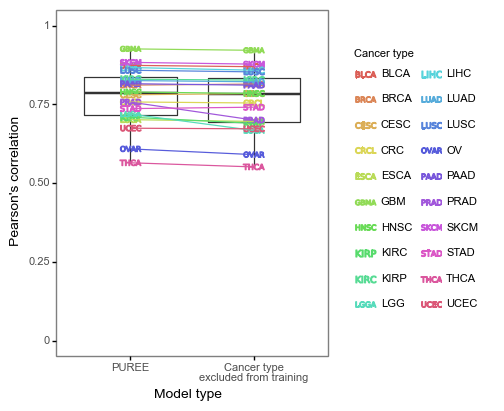

<ggplot: (8777133196207)>

In [9]:
metric_name = 'correlation'

import re

experiment_type = 'one_ctype_out'
model_name = 'LinearRegression'
pancan_model_name = model_name
feature_set = 'wf_full_linear-rt_chrom_filt'
data_type = 'full'
# load the results
purities_save_path = "../data/purities/TCGA_8K/model_tests/{0}/{1}/".format(experiment_type, model_name)
set_type = 'test'

results_one_out = dict()
consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)

paths = [file for file in os.listdir(purities_save_path) if (feature_set in file) and (data_type in file)]

for file in paths:
    res = pd.read_csv(purities_save_path + file, index_col=[0,1])
    ctype = re.split('_|\\.', file)[-2]
    results_one_out[ctype] = res
    
# pancancer
purity_df_pancan = pd.read_csv('../data//purities/TCGA_8K/model_tests/full/purities_wf_full_linear-rt_chrom_filt.csv', 
                               index_col=[0,1]).loc[set_type, [pancan_model_name]].join(types_data)

metric_name = metric_name
purity_df_ls_all_ctypes = purity_df_pancan.copy().drop('type', axis=1) # not needed here, but used later
purity_df_ls_all_ctypes.columns = [model_name + '_' + feature_set + '_' + 'all_ctypes']

### preparing ctype results
purity_one_out_frames = []
purity_pancan_frames = []

purity_one_out_df_frames = [] # needed for plots later

test_index = purity_df_pancan.index

for ctype in set(types_df.type):
    # CURRENT VERSION: OO is tested on test subset of ctype samples
    temp_oo = results_one_out[ctype].loc[set_type, :]
    temp_oo = temp_oo.loc[np.intersect1d(temp_oo.index, test_index), :] #!
    purity_one_out_df_frames.append(temp_oo)
    
    # PANCAN IS TESTED ON the test subset of ctype samples
    temp_pancan = purity_df_pancan.loc[purity_df_pancan.type == ctype, :]
    
    purity_one_out_tempdf = calculate_average(temp_oo.loc[
        temp_oo.join(types_df).type == ctype, :], consensus_df, metric_name)
    purity_pancan_tempdf = calculate_average(temp_pancan, consensus_df, metric_name)
    
    purity_one_out_tempdf['type'] = ctype
    purity_pancan_tempdf['type'] = ctype
    
    purity_one_out_frames.append(purity_one_out_tempdf)
    purity_pancan_frames.append(purity_pancan_tempdf)

# one-type-out results
metric_t_one_out = pd.concat(purity_one_out_frames)
metric_t_one_out['model_type'] = 'one_ctype_out'

# not used here, but needed for scatterplots later
purity_df_ls_octp_out = pd.concat(purity_one_out_df_frames)
purity_df_ls_octp_out.columns = [model_name + '_' + feature_set + '_' + 'one_out']

# pancan results
metric_t_pancan = pd.concat(purity_pancan_frames)
metric_t_pancan = metric_t_pancan.loc[metric_t_pancan.index == pancan_model_name, :] ###!!! don't forget model name
metric_t_pancan['model_type'] = 'pancan'

metric_t = pd.concat([metric_t_pancan, metric_t_one_out])
metric_t['training_mode'] = metric_t.model_type # for connected barplots later
metric_t.model_type = metric_t.model_type.map(lambda x: x+'_{0}_{1}'.format(model_name, feature_set))

### used later, in "several models - 1 plot"
metric_t_eqst_lassocv = metric_t.copy()

metric_t_eqst_lassocv_mod = metric_t_eqst_lassocv.copy()
metric_t_eqst_lassocv_mod['training_mode_ct'] = metric_t_eqst_lassocv_mod['type'] + '_' + metric_t_eqst_lassocv_mod['training_mode']
metric_t_eqst_lassocv_mod['training_mode_fs'] = metric_t_eqst_lassocv_mod['training_mode'] + '_reduced'
metric_t_eqst_lassocv_mod['type_feature_set'] = metric_t_eqst_lassocv_mod['type'] + '_reduced'

_, pval_reduced = stats.wilcoxon(metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'pancan'].sort_values(by='type')[metric_name], 
                              metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'one_ctype_out'].sort_values(by='type')[metric_name])
median_delta_reduced = np.abs((metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'pancan'].sort_values(by='type')[metric_name].median() - 
        metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'one_ctype_out'].sort_values(by='type')[metric_name].median()))
# correlation: pval = 0.0005, mean delta = 0.0004

x_order = [
    'pancan_reduced',
    'one_ctype_out_reduced',
          ]

shapes = (r"$\mathrm{BLCA}$", r"$\mathrm{BRCA}$", r"$\mathrm{CESC}$", r"$\mathrm{CRCL}$", r"$\mathrm{ESCA}$", 
          r"$\mathrm{GBMA}$", r"$\mathrm{HNSC}$", r"$\mathrm{KIRP}$", r"$\mathrm{KIRC}$", r"$\mathrm{LGGA}$",
          r"$\mathrm{LIHC}$", r"$\mathrm{LUAD}$", r"$\mathrm{LUSC}$", r"$\mathrm{OVAR}$",r"$\mathrm{PAAD}$", 
          r"$\mathrm{PRAD}$", r"$\mathrm{SKCM}$", r"$\mathrm{STAD}$", r"$\mathrm{THCA}$", r"$\mathrm{UCEC}$")

p = (ggplot(metric_t_eqst_lassocv_mod, aes(x='training_mode_fs', y=metric_name))
     + geom_boxplot(outlier_shape='')
     + geom_point(aes(color='type', shape='type'), size=8)
     + geom_line(aes(group='type_feature_set', color='type'), show_legend=False)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
            text=element_text(size=8),
            axis_title=element_text(size=10),
            axis_text=element_text(size=8),
            legend_text=element_text(size=8),
            legend_title=element_text(size=8),
            legend_key_size=1,
            figure_size=(3.5, 4.5))
     + guides(shape=guide_legend(ncol=2))
     + ylim(0, 1) # correlation
     + labs(y='{0}'.format("Pearson's correlation"), 
            x='Model type',
            color='Cancer type')
     + scale_x_discrete(limits=x_order,
                       labels=[
                           'PUREE',
                           'Cancer type\nexcluded from training'
                              ])
     + scale_shape_manual(name='Cancer type', values=shapes)
)

# p.save('../plots/main/3b_corr.pdf')
p

#### RMSE

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 4.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/3b_rmse.pdf


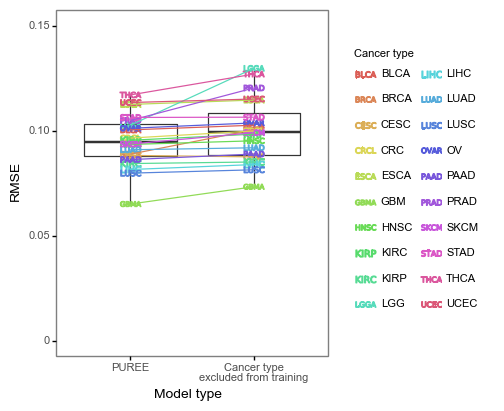

<ggplot: (8777124303442)>

In [10]:
metric_name = 'rmse'

## reading results for cancer-specific models 

import re

experiment_type = 'one_ctype_out'
model_name = 'LinearRegression'
pancan_model_name = model_name
feature_set = 'wf_full_linear-rt_chrom_filt'
data_type = 'full'
# load the results
purities_save_path = "../data/purities/TCGA_8K/model_tests/{0}/{1}/".format(experiment_type, model_name)
set_type = 'test'

results_one_out = dict()
consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)

paths = [file for file in os.listdir(purities_save_path) if (feature_set in file) and (data_type in file)]

for file in paths:
    res = pd.read_csv(purities_save_path + file, index_col=[0,1])
    ctype = re.split('_|\\.', file)[-2]
    results_one_out[ctype] = res
    
# pancancer
purity_df_pancan = pd.read_csv('../data//purities/TCGA_8K/model_tests/full/purities_wf_full_linear-rt_chrom_filt.csv', 
                               index_col=[0,1]).loc[set_type, [pancan_model_name]].join(types_data)

metric_name = metric_name
purity_df_ls_all_ctypes = purity_df_pancan.copy().drop('type', axis=1) # not needed here, but used later
purity_df_ls_all_ctypes.columns = [model_name + '_' + feature_set + '_' + 'all_ctypes']

### preparing ctype results
purity_one_out_frames = []
purity_pancan_frames = []

purity_one_out_df_frames = [] # needed for plots later

test_index = purity_df_pancan.index

for ctype in set(types_df.type):
    # CURRENT VERSION: OO is tested on test subset of ctype samples
    temp_oo = results_one_out[ctype].loc[set_type, :]
    temp_oo = temp_oo.loc[np.intersect1d(temp_oo.index, test_index), :] #!
    purity_one_out_df_frames.append(temp_oo)
    
    # PANCAN IS TESTED ON the test subset of ctype samples
    temp_pancan = purity_df_pancan.loc[purity_df_pancan.type == ctype, :]
    
    purity_one_out_tempdf = calculate_average(temp_oo.loc[
        temp_oo.join(types_df).type == ctype, :], consensus_df, metric_name)
    purity_pancan_tempdf = calculate_average(temp_pancan, consensus_df, metric_name)
    
    purity_one_out_tempdf['type'] = ctype
    purity_pancan_tempdf['type'] = ctype
    
    purity_one_out_frames.append(purity_one_out_tempdf)
    purity_pancan_frames.append(purity_pancan_tempdf)

# one-type-out results
metric_t_one_out = pd.concat(purity_one_out_frames)
metric_t_one_out['model_type'] = 'one_ctype_out'

# not used here, but needed for scatterplots later
purity_df_ls_octp_out = pd.concat(purity_one_out_df_frames)
purity_df_ls_octp_out.columns = [model_name + '_' + feature_set + '_' + 'one_out']

# pancan results
metric_t_pancan = pd.concat(purity_pancan_frames)
metric_t_pancan = metric_t_pancan.loc[metric_t_pancan.index == pancan_model_name, :] ###!!! don't forget model name
metric_t_pancan['model_type'] = 'pancan'

metric_t = pd.concat([metric_t_pancan, metric_t_one_out])
metric_t['training_mode'] = metric_t.model_type # for connected barplots later
metric_t.model_type = metric_t.model_type.map(lambda x: x+'_{0}_{1}'.format(model_name, feature_set))

### used later, in "several models - 1 plot"
metric_t_eqst_lassocv = metric_t.copy()

metric_t_eqst_lassocv_mod = metric_t_eqst_lassocv.copy()
metric_t_eqst_lassocv_mod['training_mode_ct'] = metric_t_eqst_lassocv_mod['type'] + '_' + metric_t_eqst_lassocv_mod['training_mode']
metric_t_eqst_lassocv_mod['training_mode_fs'] = metric_t_eqst_lassocv_mod['training_mode'] + '_reduced'
metric_t_eqst_lassocv_mod['type_feature_set'] = metric_t_eqst_lassocv_mod['type'] + '_reduced'

_, pval_reduced = stats.wilcoxon(metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'pancan'].sort_values(by='type')[metric_name], 
                              metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'one_ctype_out'].sort_values(by='type')[metric_name])
median_delta_reduced = np.abs((metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'pancan'].sort_values(by='type')[metric_name].median() - 
        metric_t_eqst_lassocv[metric_t_eqst_lassocv['training_mode'] == 'one_ctype_out'].sort_values(by='type')[metric_name].median()))
# rmse: pval = 6e-06, med delta = 0.005

x_order = [
    'pancan_reduced',
    'one_ctype_out_reduced',
          ]

shapes = (r"$\mathrm{BLCA}$", r"$\mathrm{BRCA}$", r"$\mathrm{CESC}$", r"$\mathrm{CRCL}$", r"$\mathrm{ESCA}$", 
          r"$\mathrm{GBMA}$", r"$\mathrm{HNSC}$", r"$\mathrm{KIRP}$", r"$\mathrm{KIRC}$", r"$\mathrm{LGGA}$",
          r"$\mathrm{LIHC}$", r"$\mathrm{LUAD}$", r"$\mathrm{LUSC}$", r"$\mathrm{OVAR}$",r"$\mathrm{PAAD}$", 
          r"$\mathrm{PRAD}$", r"$\mathrm{SKCM}$", r"$\mathrm{STAD}$", r"$\mathrm{THCA}$", r"$\mathrm{UCEC}$")

p = (ggplot(metric_t_eqst_lassocv_mod, aes(x='training_mode_fs', y=metric_name))
     + geom_boxplot(outlier_shape='')
     + geom_point(aes(color='type', shape='type'), size=8)
     + geom_line(aes(group='type_feature_set', color='type'), show_legend=False)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
            text=element_text(size=8),
            axis_title=element_text(size=10),
            axis_text=element_text(size=8),
            legend_text=element_text(size=8),
            legend_title=element_text(size=8),
            legend_key_size=1,
            figure_size=(3.5, 4.5))
     + guides(shape=guide_legend(ncol=2))
     + ylim(0, 0.15) # rmse
     + labs(y='{0}'.format("RMSE"),
            x='Model type',
            color='Cancer type')
     + scale_x_discrete(limits=x_order,
                       labels=[
                           'PUREE',
                           'Cancer type\nexcluded from training'
                              ])
     + scale_shape_manual(name='Cancer type', values=shapes)
)

# p.save('../plots/main/3b_rmse.pdf')
p

## Figure 4: "Comparing PUREE and existing methods on TCGA data"

In [12]:
# load the results
purities_save_path = "../data/purities/TCGA_8K/model_tests/full/"

consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)
types = set(types_df.type)

dataset_type = 'test'

estimate_pur = pd.read_csv("../data/purities/TCGA_8K/ESTIMATE_purities.tsv", sep='\t')
demixt_pur = pd.read_csv("../data/purities/TCGA_8K/DeMixT_{0}_purities.csv".format(dataset_type), index_col=0)
cibersort_pur = pd.read_csv("../data/purities/TCGA_8K/CIBERSORTx_{0}_purities.csv".format(dataset_type), index_col=0)
linseed_pur = 1 - pd.read_csv("../data/purities/TCGA_8K/LinSeed_{0}_proportions.csv".format(dataset_type), index_col=0).iloc[:,[0]]
linseed_pur.columns = ['LinSeed']
epic_pur = pd.read_csv("../data/purities/TCGA_8K/EPIC_{0}_purities.csv".format(dataset_type), index_col=0)
deconrnaseq_pur = pd.read_csv("../data/purities/TCGA_8K/DeconRNASeq_{0}_purities.csv".format(dataset_type), index_col=0)

feature_set = 'wf_full_linear-rt_chrom_filt' # 
model = 'LinearRegression'
for file in np.sort(os.listdir(purities_save_path)):
    if feature_set in file: 
        predicted_purity_df = (pd.read_csv('../data/purities/TCGA_8K/model_tests/full/{0}'.format(file), index_col=[0,1])
                               .loc[:, [model]])
        break

predicted_purity_df.columns = ['PUREE']

predicted_purity_df.loc[predicted_purity_df[(predicted_purity_df > 1).PUREE].index] = 1
predicted_purity_df.loc[predicted_purity_df[(predicted_purity_df < 0).PUREE].index] = 0

### a) Correlation

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/4a_corr.pdf
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: Yo

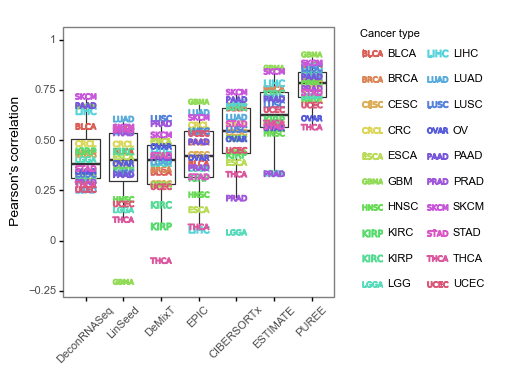

<ggplot: (8777133293707)>

In [14]:
metric_name = 'correlation'

metric_t = []
metric_t_df = calculate_average_by_type(predicted_purity_df.loc[dataset_type, :], consensus_df, 
                                        types_df, metric_name)
index = predicted_purity_df.loc[dataset_type, :].index
metric_t_df = metric_t_df.sort_values(by=metric_name, ascending=False)
metric_t.append(metric_t_df)
metric_t = pd.concat(metric_t)

metric_t_estimate = calculate_average_by_type(estimate_pur.reindex(index).dropna(), 
                                              consensus_df, types_df, metric_name=metric_name)

metric_t_demixt = calculate_average_by_type(demixt_pur.reindex(index).dropna(), 
                                            consensus_df, types_df, metric_name=metric_name)

metric_t_cibersort = calculate_average_by_type(cibersort_pur.reindex(index).dropna(), 
                                               consensus_df, types_df, metric_name=metric_name)

metric_t_linseed = calculate_average_by_type(linseed_pur.reindex(index).dropna(), 
                                             consensus_df, types_df, metric_name=metric_name)

metric_t_epic = calculate_average_by_type(epic_pur.reindex(index).dropna(), 
                                             consensus_df, types_df, metric_name=metric_name)

metric_t_deconrnaseq = calculate_average_by_type(deconrnaseq_pur.reindex(index).dropna(), 
                                             consensus_df, types_df, metric_name=metric_name)


metric_t = pd.concat([
    metric_t, 
                      metric_t_estimate, 
                      metric_t_demixt,
                      metric_t_linseed,
                      metric_t_cibersort,
                      metric_t_epic,
                      metric_t_deconrnaseq
                     ])

metric_t_corr = metric_t.copy()

x_order = metric_t.groupby(metric_t.index).median().sort_values(metric_name, ascending=True).index # use the last metric

# plotting

shapes = (r"$\mathrm{BLCA}$", r"$\mathrm{BRCA}$", r"$\mathrm{CESC}$", r"$\mathrm{CRCL}$", r"$\mathrm{ESCA}$", 
          r"$\mathrm{GBMA}$", r"$\mathrm{HNSC}$", r"$\mathrm{KIRP}$", r"$\mathrm{KIRC}$", r"$\mathrm{LGGA}$",
          r"$\mathrm{LIHC}$", r"$\mathrm{LUAD}$", r"$\mathrm{LUSC}$", r"$\mathrm{OVAR}$",r"$\mathrm{PAAD}$", 
          r"$\mathrm{PRAD}$", r"$\mathrm{SKCM}$", r"$\mathrm{STAD}$", r"$\mathrm{THCA}$", r"$\mathrm{UCEC}$")

p = (ggplot(metric_t, aes(x=metric_t.index, y=metric_name))
 + geom_boxplot(outlier_shape='')

 + geom_point(aes(color=metric_t.type, shape=metric_t.type), size=8)
 + scale_x_discrete(limits=x_order)
 + theme_bw()
 + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        axis_text_x=element_text(rotation=45, size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=1,
        figure_size=(3.5, 3.5))
 + guides(shape=guide_legend(ncol=2))
 + ylim(-0.22,1)
 + labs(y='{0}'.format("Pearson's correlation"), 
        color='Cancer type')
 + scale_shape_manual(name='Cancer type', values=shapes)
)

# p.save('../plots/main/4a_corr.pdf')
p

### a) RMSE

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/4a_rmse.pdf
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff', '#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packa

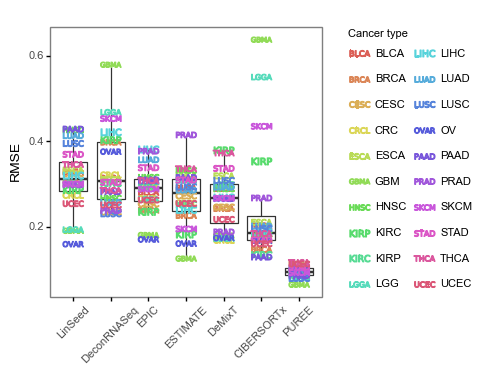

<ggplot: (8777123942660)>

In [15]:
metric_name = 'rmse'

metric_t = []
metric_t_df = calculate_average_by_type(predicted_purity_df.loc['test', :], consensus_df, 
                                        types_df, metric_name)
test_index = predicted_purity_df.loc[dataset_type, :].index
metric_t_df = metric_t_df.sort_values(by=metric_name, ascending=False)
metric_t.append(metric_t_df)
metric_t = pd.concat(metric_t)

metric_t_estimate = calculate_average_by_type(estimate_pur.reindex(index).dropna(), 
                                              consensus_df, types_df, metric_name=metric_name)

metric_t_demixt = calculate_average_by_type(demixt_pur.reindex(index).dropna(), 
                                            consensus_df, types_df, metric_name=metric_name)

metric_t_cibersort = calculate_average_by_type(cibersort_pur.reindex(index).dropna(), 
                                               consensus_df, types_df, metric_name=metric_name)

metric_t_linseed = calculate_average_by_type(linseed_pur.reindex(index).dropna(), 
                                             consensus_df, types_df, metric_name=metric_name)

metric_t_epic = calculate_average_by_type(epic_pur.reindex(index).dropna(), 
                                             consensus_df, types_df, metric_name=metric_name)

metric_t_deconrnaseq = calculate_average_by_type(deconrnaseq_pur.reindex(index).dropna(), 
                                             consensus_df, types_df, metric_name=metric_name)


metric_t = pd.concat([
    metric_t, 
                      metric_t_estimate, 
                      metric_t_demixt,
                      metric_t_linseed,
                      metric_t_cibersort,
                      metric_t_epic,
                      metric_t_deconrnaseq
                     ])

metric_t_rmse = metric_t.copy()

x_order = metric_t.groupby(metric_t.index).median().sort_values(metric_name, ascending=False).index # use the last metric

# plotting
shapes = (r"$\mathrm{BLCA}$", r"$\mathrm{BRCA}$", r"$\mathrm{CESC}$", r"$\mathrm{CRCL}$", r"$\mathrm{ESCA}$", 
          r"$\mathrm{GBMA}$", r"$\mathrm{HNSC}$", r"$\mathrm{KIRP}$", r"$\mathrm{KIRC}$", r"$\mathrm{LGGA}$",
          r"$\mathrm{LIHC}$", r"$\mathrm{LUAD}$", r"$\mathrm{LUSC}$", r"$\mathrm{OVAR}$",r"$\mathrm{PAAD}$", 
          r"$\mathrm{PRAD}$", r"$\mathrm{SKCM}$", r"$\mathrm{STAD}$", r"$\mathrm{THCA}$", r"$\mathrm{UCEC}$")

p = (ggplot(metric_t, aes(x=metric_t.index, y=metric_name))
 + geom_boxplot(outlier_shape='')
 + geom_point(aes(color=metric_t.type, shape=metric_t.type), size=8)
 + scale_x_discrete(limits=x_order)
 + theme_bw()
 + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        axis_text_x=element_text(rotation=45, size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=1,
        figure_size=(3.5, 3.5))
 + guides(shape=guide_legend(ncol=2))
 + labs(y=metric_name.upper(), 
        color='Cancer type')
 + scale_shape_manual(name='Cancer type', values=shapes)
)

# p.save('../plots/main/4a_rmse.pdf')
p

### b) Correlation+RMSE bubble plots

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 3 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/4b.pdf


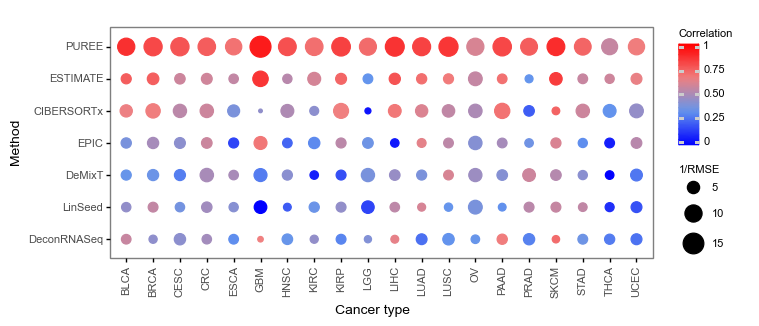

<ggplot: (8777123992299)>

In [16]:
metric_t_all = metric_t_rmse.set_index('type', append=True).join(metric_t_corr.set_index('type', append=True))
metric_t_all = metric_t_all.reset_index()
metric_t_all = metric_t_all.rename({'level_0':'method'}, axis=1)
metric_t_all['1/rmse'] = 1/metric_t_all.rmse

cohort_order = list(metric_t_all.groupby('method').median().sort_values(by='correlation').index)

p = (ggplot(metric_t_all, aes(x='type', y='method')) 
    + geom_point(aes(size='1/rmse', color='correlation'))
    + labs(y="Method", x="Cancer type",  
           color="Correlation", size="1/RMSE")
    + theme_bw()
    + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        axis_text_x=element_text(rotation=90,size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=10,
        figure_size=(7, 3))
    + scale_colour_gradientn(colors=('blue', 'cornflowerblue', 'lightcoral', 'red'), limits=(0,1))
    + scale_size_continuous(range=(1, 8))
     + scale_y_discrete(limits=cohort_order)
)

# p.save('../plots/main/4b.pdf')
p

## Figure 5: "Benchmarking of methods on independent datasets"
Run the next 4 sections first to load the data for the plot generation

### TCGA-test (1500 samples from TCGA, mixed cancer types)

In [17]:
purities_save_path = "../data/purities/TCGA_8K/model_tests/full/"

dataset_type = 'test'

feature_set = 'wf_full_linear-rt_chrom_filt' # 158 fs

model = 'LinearRegression'
for file in np.sort(os.listdir(purities_save_path)):
    if feature_set in file: 
        predicted_purity_df = (pd.read_csv('../data/purities/TCGA_8K/model_tests/full/{0}'.format(file), index_col=[0,1])
                               .loc[dataset_type, [model]])
        break

predicted_purity_df.columns = ['PUREE']
idx = predicted_purity_df.index

predicted_purity_df.loc[predicted_purity_df[(predicted_purity_df > 1).PUREE].index] = 1
predicted_purity_df.loc[predicted_purity_df[(predicted_purity_df < 0).PUREE].index] = 0

types_df = pd.read_csv("../data/misc/types_data.csv", index_col=0)
types = set(types_df['type'])

estimate_pur = pd.read_csv("../data/purities/TCGA_8K/ESTIMATE_purities.tsv", sep='\t')
demixt_pur = pd.read_csv("../data/purities/TCGA_8K/DeMixT_{0}_purities.csv".format(dataset_type), index_col=0)
cibersort_pur = pd.read_csv("../data/purities/TCGA_8K/CIBERSORTx_{0}_purities.csv".format(dataset_type), index_col=0)
linseed_pur = 1 - pd.read_csv("../data/purities/TCGA_8K/LinSeed_{0}_proportions.csv".format(dataset_type), index_col=0).iloc[:,[0]]
linseed_pur.columns = ['LinSeed']
epic_pur = pd.read_csv("../data/purities/TCGA_8K/EPIC_{0}_purities.csv".format(dataset_type), index_col=0)
deconrnaseq_pur = pd.read_csv("../data/purities/TCGA_8K/DeconRNASeq_{0}_purities.csv".format(dataset_type), index_col=0)

consensus_df = pd.read_csv("../data/purities/TCGA_8K/consensus_purities_new_g.csv", index_col=0)
consensus_df = consensus_df.loc[predicted_purity_df.index, :]
consensus_df.columns = ['Consensus']

all_purities = pd.concat([estimate_pur,
                          demixt_pur,
                          cibersort_pur,
                          epic_pur,
                          linseed_pur,
                          deconrnaseq_pur,
                          predicted_purity_df,
                          ], axis=1)

compare_with = consensus_df['Consensus'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index].dropna()
    compare_with_without_na = compare_with.loc[method_pur.index]

    correlation = np.corrcoef(method_pur, compare_with_without_na)[0, 1]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with_without_na))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_tcga = metrics_df.copy()  # used later in circle heatmaps
metrics_df_tcga['Cohort'] = 'TCGA (test set)'

pur_melted = consensus_df.join(all_purities).melt(id_vars='Consensus', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'Consensus':'genomic purity'}, axis=1)
pur_melted_tcga = pur_melted.copy()
pur_melted_tcga.method = 'TCGA (test set): ' + pur_melted_tcga.method

### Chen et al. (Lung cancer)
https://www-nature-com.ejproxy.a-star.edu.sg/articles/s41588-019-0569-6?proof=true#data-availability

In [18]:
####

purity_puree = pd.read_csv("../data/purities/Chen_et_al/PUREE_Chen_et_al_purities.tsv", sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_demixt = pd.read_csv("../data/purities/Chen_et_al/DeMixT_Chen_et_al_purities.csv", index_col=0)
purity_demixt.columns = ['DeMixT']

purity_cibersortx = pd.read_csv("../data/purities/Chen_et_al/CIBERSORTx_Chen_et_al_purities.csv", index_col=0)
purity_cibersortx.columns = ['CIBERSORTx']

purity_linseed = 1-pd.read_csv("../data/purities/Chen_et_al/LinSeed_Chen_et_al_proportions.csv", index_col=0).iloc[:,[1]]
purity_linseed.columns = ['LinSeed']

purity_epic = pd.read_csv("../data/purities/Chen_et_al/EPIC_Chen_et_al_purities.csv", index_col=0)
purity_epic.columns = ['EPIC']

purity_estimate = pd.read_csv("../data/purities/Chen_et_al/ESTIMATE_Chen_et_al_purities.csv", index_col=0).T
purity_estimate.columns=['ESTIMATE']

purity_deconrnaseq = pd.read_csv("../data/purities/Chen_et_al/DeconRNASeq_Chen_et_al_purities.csv", index_col=0)
purity_deconrnaseq.columns=['DeconRNASeq']

genomic_purities = (pd.read_csv("../data/purities/Chen_et_al/Chen_et_al_genomic_purities.tsv", sep='\t', index_col=0)
                    .reindex(purity_puree.index))

all_purities = pd.concat([
    purity_puree,
    purity_estimate,
    purity_cibersortx,
    purity_demixt, 
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)

compare_with = genomic_purities['Average'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_chen_et_al = metrics_df.copy()  # used later in circle heatmaps
metrics_df_chen_et_al['Cohort'] = 'Chen et al.'

pur_melted = genomic_purities.loc[:, ['Average']].join(all_purities).melt(id_vars='Average', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'Average':'genomic purity'}, axis=1)
pur_melted_chen_et_al = pur_melted.copy()
pur_melted_chen_et_al.method = 'Chen et al.: ' + pur_melted_chen_et_al.method

### Chua et al. (Lung cancer)
https://aacrjournals.org/clincancerres/article/27/21/5939/671726/Integrative-Profiling-of-T790M-Negative-EGFR

In [19]:
purity_puree = pd.read_csv("../data/purities/Chua_et_al/PUREE_Chua_et_al_purities.tsv", sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_estimate = (pd.read_csv('../data/purities/Chua_et_al/ESTIMATE_Chua_et_al_purities.csv', index_col=0).T
                      .reindex(purity_puree.index))

purity_epic = (pd.read_csv('../data/purities/Chua_et_al/EPIC_Chua_et_al_purities.csv', index_col=0)
                      .reindex(purity_puree.index))

purity_linseed = 1-(pd.read_csv('../data/purities/Chua_et_al/LinSeed_Chua_et_al_proportions.csv', index_col=0).iloc[:,[0]]
                      .reindex(purity_puree.index))
purity_linseed.columns = ['LinSeed']

purity_cibersortx = (pd.read_csv('../data/purities/Chua_et_al/CIBERSORTx_Chua_et_al_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_cibersortx.columns = ['CIBERSORTx']

purity_deconrnaseq = (pd.read_csv("../data/purities/Chua_et_al/DeconRNASeq_Chua_et_al_purities.csv", index_col=0)
                      .reindex(purity_puree.index))
purity_deconrnaseq.columns=['DeconRNASeq']

genomic_purities = (pd.read_csv("../data/purities/Chua_et_al/Chua_et_al_purity_estimates.tsv", sep='\t', index_col=0)[['Average']]
                   .loc[purity_puree.index])

all_purities = pd.concat([
    purity_puree,
    purity_estimate,
    purity_cibersortx,
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)
compare_with = genomic_purities['Average'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_chua_et_al = metrics_df.copy()  # used later in circle heatmaps
metrics_df_chua_et_al['Cohort'] = 'Chua et al.'

pur_melted = genomic_purities.join(all_purities).melt(id_vars='Average', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'Average':'genomic purity'}, axis=1)
pur_melted_chua_et_al = pur_melted.copy()
pur_melted_chua_et_al.method = 'Chua et al.: ' + pur_melted_chua_et_al.method

### Joanito et al. (colorectal cancer)

In [20]:
######

purity_puree = pd.read_csv("../data/purities/Joanito_et_al/PUREE_Joanito_et_al_purities.tsv", sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_estimate = (pd.read_csv('../data/purities/Joanito_et_al/ESTIMATE_Joanito_et_al_purities.tsv', sep='\t', 
                              index_col=0).reindex(purity_puree.index))

purity_epic = (pd.read_csv('../data/purities/Joanito_et_al/EPIC_Joanito_et_al_purities.csv', index_col=0)
                      .reindex(purity_puree.index))

purity_linseed = 1-(pd.read_csv('../data/purities/Joanito_et_al/LinSeed_Joanito_et_al_proportions.csv', index_col=0)
                      .reindex(purity_puree.index).iloc[:,[0]])
purity_linseed.columns=['LinSeed']

purity_cibersortx = (pd.read_csv('../data/purities/Joanito_et_al/CIBERSORTx_Joanito_et_al_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_cibersortx.columns = ['CIBERSORTx']

purity_deconrnaseq = (pd.read_csv("../data/purities/Joanito_et_al/DeconRNASeq_Joanito_et_al_purities.csv", index_col=0)
                      .reindex(purity_puree.index))
purity_deconrnaseq.columns=['DeconRNASeq']

consensus_joanito = (pd.read_csv("../data/purities/Joanito_et_al/Joanito_et_al_genomic_consensus_purities.tsv", sep='\t', index_col=0)
    .reindex(purity_puree.index))
consensus_joanito.columns = ['Consensus']

all_purities = pd.concat([
    purity_estimate,
    purity_cibersortx,
    purity_puree,
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)

compare_with = consensus_joanito['Consensus'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_joanito = metrics_df.copy()  # used later in circle heatmaps
metrics_df_joanito['Cohort'] = 'Joanito et al.'

pur_melted = consensus_joanito.join(all_purities).melt(id_vars='Consensus', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'Consensus':'genomic purity'}, axis=1)
pur_melted_joanito = pur_melted.copy()
pur_melted_joanito.method = 'Joanito et al.: ' + pur_melted_joanito.method

### TCGA (data outside of the training set)

#### TCGA-CRC+ (Colorectal cancer)

In [21]:
###### 243 samples

purity_puree = pd.read_csv("../data/purities/TCGA_extra/CRC+/PUREE_TCGA-CRC_new_htseq_fpkm_formatted_purities.tsv", 
                           sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_estimate = (pd.read_csv('../data/purities/TCGA_extra/CRC+/ESTIMATE_TCGA_CRC_new_purities.csv',
                              index_col=0).reindex(purity_puree.index))

purity_epic = (pd.read_csv('../data/purities/TCGA_extra/CRC+/EPIC_TCGA_CRC_new_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_epic.columns=['EPIC']

purity_demixt = pd.read_csv("../data/purities/TCGA_extra/CRC+/DeMixT_TCGA_CRC_new_purities.csv", index_col=0)
purity_demixt.columns = ['DeMixT']

purity_linseed = 1-(pd.read_csv('../data/purities/TCGA_extra/CRC+/LinSeed_TCGA_CRC_new_proportions.csv', index_col=0)
                      .reindex(purity_puree.index).iloc[:,[1]])
purity_linseed.columns=['LinSeed']

purity_cibersortx = (pd.read_csv('../data/purities/TCGA_extra/CRC+/CIBERSORTx_TCGA_CRC_new_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_cibersortx.columns = ['CIBERSORTx']

purity_deconrnaseq = (pd.read_csv("../data/purities/TCGA_extra/CRC+/DeconRNASeq_TCGA_CRC_new_purities.csv", index_col=0)
                      .reindex(purity_puree.index))
purity_deconrnaseq.columns=['DeconRNASeq']

consensus_tcga_crc = (pd.read_csv("../data/purities/TCGA_extra/CRC+/ABSOLUTE_TCGA-CRC_new_htseq_fpkm_formatted_purities.tsv", sep='\t', index_col=0)
    .reindex(purity_puree.index))
consensus_tcga_crc.columns = ['ABSOLUTE']

all_purities = pd.concat([
    purity_estimate,
    purity_demixt,
    purity_cibersortx,
    purity_puree,
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)

compare_with = consensus_tcga_crc['ABSOLUTE'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_tcga_crc = metrics_df.copy()  # used later in circle heatmaps
metrics_df_tcga_crc['Cohort'] = 'TCGA-CRC'

pur_melted = consensus_tcga_crc.join(all_purities).melt(id_vars='ABSOLUTE', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'ABSOLUTE':'genomic purity'}, axis=1)
pur_melted_tcga_crc = pur_melted.copy()
pur_melted_tcga_crc.method = 'TCGA-CRC+: ' + pur_melted_tcga_crc.method

#### TCGA-UCEC+ (Uterine cancer)

In [22]:
###### 353 samples

purity_puree = pd.read_csv("../data/purities/TCGA_extra/UCEC+/PUREE_TCGA-UCEC_new_htseq_fpkm_formatted_purities.tsv", 
                           sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_estimate = (pd.read_csv('../data/purities/TCGA_extra/UCEC+/ESTIMATE_TCGA_UCEC_new_purities.csv',
                              index_col=0).reindex(purity_puree.index))

purity_epic = (pd.read_csv('../data/purities/TCGA_extra/UCEC+/EPIC_TCGA_UCEC_new_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_epic.columns=['EPIC']

purity_demixt = pd.read_csv("../data/purities/TCGA_extra/UCEC+/DeMixT_TCGA_UCEC_new_purities.csv", index_col=0)
purity_demixt.columns = ['DeMixT']

purity_linseed = 1-(pd.read_csv('../data/purities/TCGA_extra/UCEC+/LinSeed_TCGA_UCEC_new_proportions.csv', index_col=0)
                      .reindex(purity_puree.index).iloc[:,[0]])
purity_linseed.columns=['LinSeed']

purity_cibersortx = (pd.read_csv('../data/purities/TCGA_extra/UCEC+/CIBERSORTx_TCGA_UCEC_new_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_cibersortx.columns = ['CIBERSORTx']

purity_deconrnaseq = (pd.read_csv("../data/purities/TCGA_extra/UCEC+/DeconRNASeq_TCGA_UCEC_new_purities.csv", index_col=0)
                      .reindex(purity_puree.index))
purity_deconrnaseq.columns=['DeconRNASeq']

consensus_tcga_ucec = (pd.read_csv("../data/purities/TCGA_extra/UCEC+/ABSOLUTE_TCGA-UCEC_new_htseq_fpkm_formatted_purities.tsv", sep='\t', index_col=0)
    .reindex(purity_puree.index))
consensus_tcga_ucec.columns = ['ABSOLUTE']

all_purities = pd.concat([
    purity_estimate,
    purity_demixt,
    purity_cibersortx,
    purity_puree,
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)

compare_with = consensus_tcga_ucec['ABSOLUTE'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_tcga_ucec = metrics_df.copy()  # used later in circle heatmaps
metrics_df_tcga_ucec['Cohort'] = 'TCGA-UCEC'

pur_melted = consensus_tcga_ucec.join(all_purities).melt(id_vars='ABSOLUTE', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'ABSOLUTE':'genomic purity'}, axis=1)
pur_melted_tcga_ucec = pur_melted.copy()
pur_melted_tcga_ucec.method = 'TCGA-UCEC+: ' + pur_melted_tcga_ucec.method

#### TCGA-PCPG (Paraganglioma)

In [23]:
###### 164 samples

purity_puree = pd.read_csv("../data/purities/TCGA_extra/PCPG/PUREE_TCGA-PCPG_htseq_fpkm_formatted_purities.tsv", 
                           sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_estimate = (pd.read_csv('../data/purities/TCGA_extra/PCPG/ESTIMATE_TCGA_PCPG_purities.csv',
                              index_col=0).reindex(purity_puree.index))

purity_epic = (pd.read_csv('../data/purities/TCGA_extra/PCPG/EPIC_TCGA_PCPG_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_epic.columns=['EPIC']

purity_linseed = 1-(pd.read_csv('../data/purities/TCGA_extra/PCPG/LinSeed_TCGA_PCPG_proportions.csv', index_col=0)
                      .reindex(purity_puree.index).iloc[:,[0]])
purity_linseed.columns=['LinSeed']

purity_cibersortx = (pd.read_csv('../data/purities/TCGA_extra/PCPG/CIBERSORTx_TCGA_PCPG_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_cibersortx.columns = ['CIBERSORTx']

purity_deconrnaseq = (pd.read_csv("../data/purities/TCGA_extra/PCPG/DeconRNASeq_TCGA_PCPG_purities.csv", index_col=0)
                      .reindex(purity_puree.index))
purity_deconrnaseq.columns=['DeconRNASeq']

consensus_tcga_pcpg = (pd.read_csv("../data/purities/TCGA_extra/PCPG/ABSOLUTE_TCGA-PCPG_htseq_fpkm_formatted_purities.tsv", sep='\t', index_col=0)
    .reindex(purity_puree.index))
consensus_tcga_pcpg.columns = ['ABSOLUTE']

all_purities = pd.concat([
    purity_estimate,
    purity_cibersortx,
    purity_puree,
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)

compare_with = consensus_tcga_pcpg['ABSOLUTE'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_tcga_pcpg = metrics_df.copy()  # used later in circle heatmaps
metrics_df_tcga_pcpg['Cohort'] = 'TCGA-PCPG'

pur_melted = consensus_tcga_pcpg.join(all_purities).melt(id_vars='ABSOLUTE', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'ABSOLUTE':'genomic purity'}, axis=1)
pur_melted_tcga_pcpg = pur_melted.copy()
pur_melted_tcga_pcpg.method = 'TCGA-PCPG: ' + pur_melted_tcga_pcpg.method

#### TCGA-TGCT (Testicular cancer)

In [24]:
###### 155 samples

purity_puree = pd.read_csv("../data/purities/TCGA_extra/TGCT/PUREE_TCGA-TGCT_htseq_fpkm_formatted_purities.tsv", 
                           sep='\t', index_col=0)
purity_puree.columns = ['PUREE']

purity_estimate = (pd.read_csv('../data/purities/TCGA_extra/TGCT/ESTIMATE_TCGA_TGCT_purities.csv',
                              index_col=0).reindex(purity_puree.index))

purity_epic = (pd.read_csv('../data/purities/TCGA_extra/TGCT/EPIC_TCGA_TGCT_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_epic.columns=['EPIC']

purity_linseed = 1-(pd.read_csv('../data/purities/TCGA_extra/TGCT/LinSeed_TCGA_TGCT_proportions.csv', index_col=0)
                      .reindex(purity_puree.index).iloc[:,[0]])
purity_linseed.columns=['LinSeed']

purity_cibersortx = (pd.read_csv('../data/purities/TCGA_extra/TGCT/CIBERSORTx_TCGA_TGCT_purities.csv', index_col=0)
                      .reindex(purity_puree.index))
purity_cibersortx.columns = ['CIBERSORTx']

purity_deconrnaseq = (pd.read_csv("../data/purities/TCGA_extra/TGCT/DeconRNASeq_TCGA_TGCT_purities.csv", index_col=0)
                      .reindex(purity_puree.index))
purity_deconrnaseq.columns=['DeconRNASeq']

consensus_tcga_tgct = (pd.read_csv("../data/purities/TCGA_extra/TGCT/ABSOLUTE_TCGA-TGCT_htseq_fpkm_formatted_purities.tsv", sep='\t', index_col=0)
    .reindex(purity_puree.index))
consensus_tcga_tgct.columns = ['ABSOLUTE']

all_purities = pd.concat([
    purity_estimate,
    purity_cibersortx,
    purity_puree,
    purity_linseed,
    purity_epic,
    purity_deconrnaseq,
], axis=1)

compare_with = consensus_tcga_tgct['ABSOLUTE'].dropna()

cor_metrics = []
rmse_metrics = []
methods = []


for item in all_purities.iteritems():
    method_pur = item[1].loc[compare_with.index]

    correlation = pearsonr(method_pur, compare_with)[0]
    cor_metrics.append(correlation)

    rmse = np.sqrt(mean_squared_error(method_pur, compare_with))
    rmse_metrics.append(rmse)

    methods.append(item[0])

metrics_df = pd.DataFrame(list(zip(cor_metrics, rmse_metrics, methods)),
                          columns=['Correlation', 'RMSE', 'Method'], index=methods)
metrics_df_tcga_tgct = metrics_df.copy()  # used later in circle heatmaps
metrics_df_tcga_tgct['Cohort'] = 'TCGA-TGCT'

pur_melted = consensus_tcga_tgct.join(all_purities).melt(id_vars='ABSOLUTE', ignore_index=False).dropna()
pur_melted = pur_melted.rename({'variable':'method', 'value':'predicted purity', 'ABSOLUTE':'genomic purity'}, axis=1)
pur_melted_tcga_tgct = pur_melted.copy()
pur_melted_tcga_tgct.method = 'TCGA-TGCT: ' + pur_melted_tcga_tgct.method

#### a) All cohorts - boxplots

##### Correlation

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/5a_corr.pdf
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


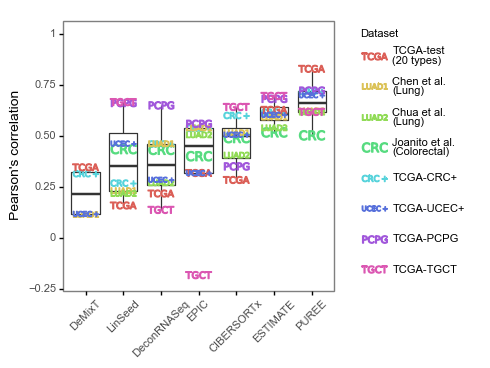

<ggplot: (8777122868986)>

In [27]:
metric_name = 'Correlation'

metrics_df_all_cohorts = pd.concat([
    metrics_df_chen_et_al,
    metrics_df_chua_et_al,
    metrics_df_joanito,
    metrics_df_tcga,
    metrics_df_tcga_crc,
    metrics_df_tcga_tgct,
    metrics_df_tcga_ucec,
    metrics_df_tcga_pcpg
])
methods = list(np.unique(metrics_df_all_cohorts['Method']))
cohorts = list(np.unique(metrics_df_all_cohorts['Cohort']))

mask = (metrics_df_all_cohorts.Method.str.contains('PUREE') | \
    metrics_df_all_cohorts.Method.str.contains('ESTIMATE') | \
    metrics_df_all_cohorts.Method.str.contains('CIBERSORTx') |
    metrics_df_all_cohorts.Method.str.contains('LinSeed') |
    metrics_df_all_cohorts.Method.str.contains('EPIC') |
    metrics_df_all_cohorts.Method.str.contains('DeMixT') |
    metrics_df_all_cohorts.Method.str.contains('DeconRNASeq')  )
metrics_df_all_cohorts = metrics_df_all_cohorts[mask]

metrics_df_all_cohorts.Cohort = metrics_df_all_cohorts.Cohort.replace({
    'TCGA (test set)':'TCGA-test\n(20 types)',
    'Chen et al.':'Chen et al.\n(Lung)',
    'Chua et al.':'Chua et al.\n(Lung)',
    'Joanito et al.':'Joanito et al.\n(Colorectal)',
    'TCGA-UCEC':'TCGA-UCEC+',
    'TCGA-TGCT':'TCGA-TGCT',
    'TCGA-CRC':'TCGA-CRC+',
    'TCGA-PCPG':'TCGA-PCPG'
})
metric_t = metrics_df_all_cohorts

x_order = metric_t.groupby(metric_t.index).median().sort_values(metric_name, ascending=True).index # use the last metric

cohorts_order = [
    'TCGA-test\n(20 types)',
    'Chen et al.\n(Lung)',
     'Chua et al.\n(Lung)',
     'Joanito et al.\n(Colorectal)',
     'TCGA-CRC+',
     'TCGA-UCEC+',
     'TCGA-PCPG',
     'TCGA-TGCT']

cohort_cat_ord = pd.Categorical(metric_t['Cohort'], categories=cohorts_order)
metric_t = metric_t.assign(cohort_cat_ord=cohort_cat_ord)

# plotting


shapes = (r"$\mathrm{TCGA}$", r"$\mathrm{LUAD1}$", r"$\mathrm{LUAD2}$",
          r"$\mathrm{CRC}$", r"$\mathrm{CRC+}$", r"$\mathrm{UCEC+}$", 
          r"$\mathrm{PCPG}$", r"$\mathrm{TGCT}$", 
          )

p = (ggplot(metric_t, aes(x=metric_t.index, y=metric_name))
 + geom_boxplot(outlier_shape='')
 + geom_point(aes(color=metric_t.cohort_cat_ord, 
                  shape=metric_t.cohort_cat_ord
                 ), size=10)
 + scale_x_discrete(limits=x_order)
 + theme_bw()
 + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        axis_text_x=element_text(rotation=45, size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=1,
        figure_size=(3.5, 3.5))
 + ylim(-0.2,1)
 + labs(y='{0}'.format("Pearson's correlation"), 
        color='Dataset')
 + scale_shape_manual(name='Dataset', values=shapes)
)

# p.save('../plots/main/5a_corr.pdf')
p

##### RMSE

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/5a_rmse.pdf
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#333333ff', '#333333ff']) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: Us

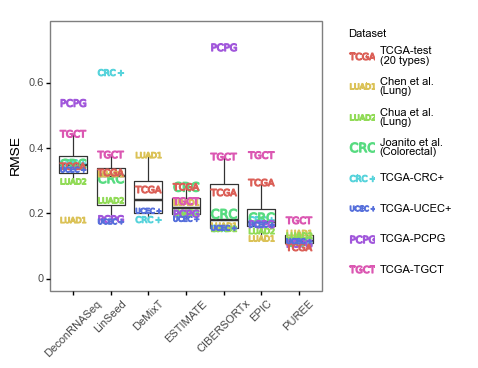

<ggplot: (8777122908218)>

In [28]:
metric_name = 'RMSE'

metrics_df_all_cohorts = pd.concat([
    metrics_df_chen_et_al,
    metrics_df_chua_et_al,
    metrics_df_joanito,
    metrics_df_tcga,
    metrics_df_tcga_crc,
    metrics_df_tcga_tgct,
    metrics_df_tcga_ucec,
    metrics_df_tcga_pcpg
])
methods = list(np.unique(metrics_df_all_cohorts['Method']))
cohorts = list(np.unique(metrics_df_all_cohorts['Cohort']))

mask = (metrics_df_all_cohorts.Method.str.contains('PUREE') | \
    metrics_df_all_cohorts.Method.str.contains('ESTIMATE') | \
    metrics_df_all_cohorts.Method.str.contains('CIBERSORTx') |
    metrics_df_all_cohorts.Method.str.contains('LinSeed') |
    metrics_df_all_cohorts.Method.str.contains('EPIC') |
    metrics_df_all_cohorts.Method.str.contains('DeMixT') |
    metrics_df_all_cohorts.Method.str.contains('DeconRNASeq')  )
metrics_df_all_cohorts = metrics_df_all_cohorts[mask]

metrics_df_all_cohorts.Cohort = metrics_df_all_cohorts.Cohort.replace({
    'TCGA (test set)':'TCGA-test\n(20 types)',
    'Chen et al.':'Chen et al.\n(Lung)',
    'Chua et al.':'Chua et al.\n(Lung)',
    'Joanito et al.':'Joanito et al.\n(Colorectal)',
    'TCGA-UCEC':'TCGA-UCEC+',
    'TCGA-TGCT':'TCGA-TGCT',
    'TCGA-CRC':'TCGA-CRC+',
    'TCGA-PCPG':'TCGA-PCPG'
})

metric_t = metrics_df_all_cohorts

x_order = metric_t.groupby(metric_t.index).median().sort_values(metric_name, ascending=False).index # use the last metric

cohorts_order = [
    'TCGA-test\n(20 types)',
    'Chen et al.\n(Lung)',
     'Chua et al.\n(Lung)',
     'Joanito et al.\n(Colorectal)',
     'TCGA-CRC+',
     'TCGA-UCEC+',
     'TCGA-PCPG',
     'TCGA-TGCT']

cohort_cat_ord = pd.Categorical(metric_t['Cohort'], categories=cohorts_order)
metric_t = metric_t.assign(cohort_cat_ord=cohort_cat_ord)

# plotting

shapes = (r"$\mathrm{TCGA}$", r"$\mathrm{LUAD1}$", r"$\mathrm{LUAD2}$",
          r"$\mathrm{CRC}$", r"$\mathrm{CRC+}$", r"$\mathrm{UCEC+}$", 
          r"$\mathrm{PCPG}$", r"$\mathrm{TGCT}$", 
          )

p = (ggplot(metric_t, aes(x=metric_t.index, y=metric_name))
     + geom_boxplot(outlier_shape='')
     + geom_point(aes(color=metric_t.cohort_cat_ord, 
                      shape=metric_t.cohort_cat_ord
                     ), size=10)
     + scale_x_discrete(limits=x_order)
     + theme_bw()
     + theme(panel_grid=element_blank(),
            legend_key=element_blank(),
            text=element_text(size=8),
            axis_title=element_text(size=10),
            axis_text=element_text(size=8),
            axis_text_x=element_text(rotation=45, size=8),
            legend_text=element_text(size=8),
            legend_title=element_text(size=8),
            legend_key_size=1,
            figure_size=(3.5, 3.5))
     + ylim(0, 0.75)
     + labs(y='{0}'.format("RMSE"), 
            color='Dataset')
     + scale_shape_manual(name='Dataset', values=shapes)
)

# p.save('../plots/main/5a_rmse.pdf')
p

#### b) All cohorts - bubble plot

/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 3 in image.
/home/ubuntu/anaconda3/envs/plotting_env/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/main/5b.pdf


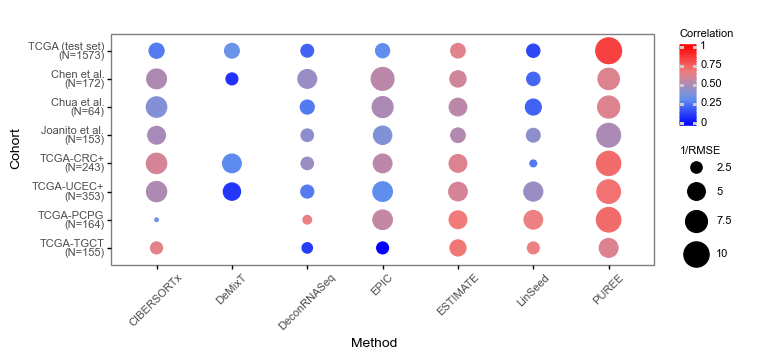

<ggplot: (8777120846090)>

In [29]:
metrics_df_all_cohorts = pd.concat([
    metrics_df_chen_et_al,
    metrics_df_chua_et_al,
    metrics_df_joanito,
    metrics_df_tcga,
    metrics_df_tcga_crc,
    metrics_df_tcga_tgct,
    metrics_df_tcga_ucec,
    metrics_df_tcga_pcpg
])
methods = list(np.unique(metrics_df_all_cohorts['Method']))
cohorts = list(np.unique(metrics_df_all_cohorts['Cohort']))

mask = (metrics_df_all_cohorts.Method.str.contains('PUREE') | \
    metrics_df_all_cohorts.Method.str.contains('ESTIMATE') | \
    metrics_df_all_cohorts.Method.str.contains('CIBERSORTx') |
    metrics_df_all_cohorts.Method.str.contains('LinSeed') |
    metrics_df_all_cohorts.Method.str.contains('EPIC') |
    metrics_df_all_cohorts.Method.str.contains('DeMixT') |
    metrics_df_all_cohorts.Method.str.contains('DeconRNASeq')  )

metrics_df_all_cohorts = metrics_df_all_cohorts[mask]

metrics_df_all_cohorts['1/RMSE'] = np.round(1 /
                                            metrics_df_all_cohorts['RMSE'], 2)
metrics_df_all_cohorts['Correlation'] = np.round(
    metrics_df_all_cohorts['Correlation'], 2)

metrics_df_all_cohorts.Cohort = metrics_df_all_cohorts.Cohort.replace({
    'TCGA (test set)':'TCGA (test set)\n(N=1573)',
    'Chen et al.':'Chen et al.\n(N=172)',
    'Chua et al.':'Chua et al.\n(N=64)',
    'Joanito et al.':'Joanito et al.\n(N=153)',
    'TCGA-UCEC':'TCGA-UCEC+\n(N=353)',
    'TCGA-TGCT':'TCGA-TGCT\n(N=155)',
    'TCGA-CRC':'TCGA-CRC+\n(N=243)',
    'TCGA-PCPG':'TCGA-PCPG\n(N=164)'
})

cohort_order = [
    'TCGA (test set)\n(N=1573)',
    'Chen et al.\n(N=172)',
    'Chua et al.\n(N=64)',
    'Joanito et al.\n(N=153)',
    'TCGA-CRC+\n(N=243)',
    'TCGA-UCEC+\n(N=353)',
    'TCGA-PCPG\n(N=164)',
    'TCGA-TGCT\n(N=155)',
][::-1]

p = (ggplot(metrics_df_all_cohorts, aes(x='Method', y='Cohort'))
    + geom_point(aes(size='1/RMSE', color='Correlation'))
    + labs(y='Cohort', x='Method', 
           color="Correlation", size="1/RMSE")
    + theme_bw()
    + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text=element_text(size=8),
        axis_text_x=element_text(rotation=45,size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
        figure_size=(7, 3))
    + scale_colour_gradientn(colors=('blue', 'cornflowerblue', 'lightcoral', 'red'),limits=(0,1))
    + scale_size_continuous(range=(1, 10))
    + scale_y_discrete(limits=cohort_order)
 )

# p.save('../plots/main/5b.pdf')
p

## Figure 6: "PUREE’s features validation on single-cell RNA-seq data"

### a) Head and neck cancers
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE103322

#### Scatterplot

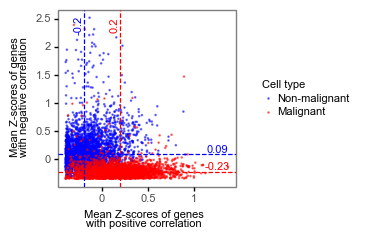

<ggplot: (8754898367425)>

In [2]:
data_zscore_mean_scat = pd.read_csv('../data/single-cell/head_and_neck/data_zcore_mean_high_and_low_corr_genes.csv', 
                                    index_col=0)

data_zscore_mean_scat['Cell type'] = (data_zscore_mean_scat['Cell type']
                                 .astype('category')
                                 .cat.reorder_categories(['Malignant',
                                                          'Non-malignant',
                                                          ][::-1]))

mal_z_high_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Malignant", 'mean_z_high'].median()
# 0.1959081912367205
mal_z_low_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Malignant", 'mean_z_low'].median()
# -0.2258588204139721
nonmal_z_high_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Non-malignant", 'mean_z_high'].median()
# -0.1953085211458445
nonmal_z_low_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Non-malignant", 'mean_z_low'].median()
# 0.0913703989854978

p = (ggplot(data_zscore_mean_scat, aes(x='mean_z_high', y='mean_z_low', color='Cell type',
                                 )) 
     + geom_point(alpha=0.5, size=0.05)
     + geom_vline(xintercept=mal_z_high_med, color='red', linetype='dashed')
     + geom_hline(yintercept=mal_z_low_med, color='red', linetype='dashed')
     + geom_vline(xintercept=nonmal_z_high_med, color='blue', linetype='dashed')
     + geom_hline(yintercept=nonmal_z_low_med, color='blue', linetype='dashed')
     + annotate("text", x=mal_z_high_med, label=np.round(mal_z_high_med, 2),
             y = 2.4, angle = 90, ha='right', color='red', size=8)
     + annotate("text",x=nonmal_z_high_med, label=np.round(nonmal_z_high_med, 2),
             y = 2.4, angle = 90, ha='right', color='blue', size=8)
     + annotate("text",y=mal_z_low_med, label=np.round(mal_z_low_med, 2),
             x = 1.25, va='bottom', color='red', size=8)
     + annotate("text",y=nonmal_z_low_med, label=np.round(nonmal_z_low_med, 2),
             x = 1.25, va='bottom', color='blue', size=8)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=8),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
    figure_size=(2.3, 2.3))
     + labs(
       x='Mean Z-scores of genes\nwith positive correlation', 
         y='Mean Z-scores of genes\nwith negative correlation',
          )
     + scale_color_manual(values=['blue', 'red'])
    )

# p.save('../plots/main/6a_scat.pdf')
p

#### Hist of positively correlated genes

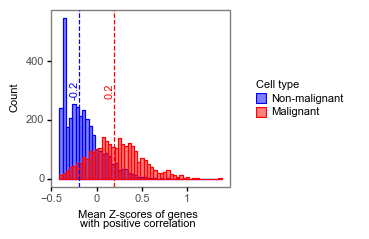

<ggplot: (8754888924474)>

In [5]:
data_zscore_mean_high_corr = pd.read_csv('../data/single-cell/head_and_neck/data_zcore_mean_high_corr_genes.csv', 
                                    index_col=0)

mal = data_zscore_mean_high_corr.loc[data_zscore_mean_high_corr['Cell type'] == 'Malignant', 'mean_z_high']
non_mal = data_zscore_mean_high_corr.loc[data_zscore_mean_high_corr['Cell type'] == 'Non-malignant', 'mean_z_high']
p_value_hcorr = mannwhitneyu(mal, non_mal)[1]
# 0.0

data_zscore_mean = data_zscore_mean_high_corr.rename({'mean_z_high':'Mean Z-score'}, axis=1)
data_zscore_mean['Cell type'] = (data_zscore_mean['Cell type']
                                 .astype('category')
                                 .cat.reorder_categories(['Malignant',
                                                          'Non-malignant',
                                                          ][::-1]))

mal_median = mal.median()
# 0.1959081912367205
non_mal_median = non_mal.median()
# -0.1953085211458445

p = (ggplot(data_zscore_mean, aes(x='Mean Z-score', fill='Cell type', color='Cell type',
                                 )) 
     + geom_histogram(position='identity', alpha=0.5, bins=50)
     + geom_vline(xintercept=mal_median, color='red', linetype='dashed')
     + geom_vline(xintercept=non_mal_median, color='blue', linetype='dashed')
     + annotate("text", x=mal_median, label=np.round(mal_median, 2),
             y = 300, angle = 90, ha='right', color='red', size=8)
     + annotate("text", x=non_mal_median+0.01, label=np.round(non_mal_median, 2),
             y = 300, angle = 90, ha='right', color='blue', size=8)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=8),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
        figure_size=(2.3, 2.3))
     + labs(
       x='Mean Z-scores of genes\nwith positive correlation', 
       y='Count', 
       fill='Cell type',
          )
     + scale_color_manual(values=['blue', 'red'])
     + scale_fill_manual(values=['blue', 'red'])
    )
# p.save('../plots/main/6a_pos.pdf')
p

#### Hist of negatively correlated genes

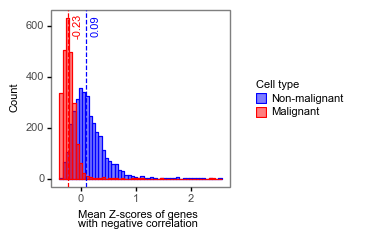

<ggplot: (8754898162375)>

In [8]:
data_zscore_mean_low_corr = pd.read_csv('../data/single-cell/head_and_neck/data_zcore_mean_low_corr_genes.csv', 
                                    index_col=0)

data_zscore_mean = data_zscore_mean_low_corr.rename({'mean_z_low':'Mean Z-score'}, axis=1)
data_zscore_mean['Cell type'] = (data_zscore_mean['Cell type']
                                 .astype('category')
                                 .cat.reorder_categories(['Malignant',
                                                          'Non-malignant',
                                                          ][::-1]))

mal = data_zscore_mean_low_corr.loc[data_zscore_mean_low_corr['Cell type'] == 'Malignant', 'mean_z_low']
non_mal = data_zscore_mean_low_corr.loc[data_zscore_mean_low_corr['Cell type'] == 'Non-malignant', 'mean_z_low']
p_value_lcorr = mannwhitneyu(mal, non_mal)[1]
# 0.0

mal_median = mal.median()
# -0.2258588204139721
non_mal_median = non_mal.median()
# 0.0913703989854978


p = (ggplot(data_zscore_mean, aes(x='Mean Z-score', fill='Cell type', color='Cell type',
                                 )) 
     + geom_histogram(position='identity', alpha=0.5, bins=50)
     + geom_vline(xintercept=mal_median, color='red', linetype='dashed')
     + geom_vline(xintercept=non_mal_median, color='blue', linetype='dashed')
     + annotate("text", x=mal_median+0.08, label=np.round(mal_median, 2),
             y = 600, angle = 90, ha='left', color='red', size=8)
     + annotate("text", x=non_mal_median+0.08, label=np.round(non_mal_median, 2),
             y = 600, angle = 90, ha='left', color='blue', size=8)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=8),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
        figure_size=(2.3, 2.3))
     + labs(
       x='Mean Z-scores of genes\nwith negative correlation', 
       y='Count', 
       fill='Cell type',
          )
     + scale_color_manual(values=['blue', 'red'])
     + scale_fill_manual(values=['blue', 'red'])
    )
# p.save('../plots/main/6a_neg.pdf')
p

### b) Melanoma
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056

#### Scatterplot

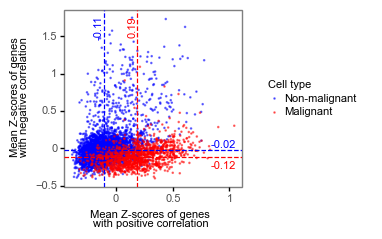

<ggplot: (8754898053380)>

In [10]:
data_zscore_mean_scat = pd.read_csv('../data/single-cell/melanoma/data_zcore_mean_high_and_low_corr_genes.csv', 
                                    index_col=0)

data_zscore_mean_scat['Cell type'] = (data_zscore_mean_scat['Cell type']
                                 .astype('category')
                                 .cat.reorder_categories(['Malignant',
                                                          'Non-malignant',
                                                          ][::-1]))

mal_z_high_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Malignant", 'mean_z_high'].median()
# 0.1871607042610495
mal_z_low_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Malignant", 'mean_z_low'].median()
# -0.1164779177387564
nonmal_z_high_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Non-malignant", 'mean_z_high'].median()
# -0.10640038785891125
nonmal_z_low_med = data_zscore_mean_scat.loc[data_zscore_mean_scat['Cell type'] == "Non-malignant", 'mean_z_low'].median()
# -0.016840960349489058


p = (ggplot(data_zscore_mean_scat, aes(x='mean_z_high', y='mean_z_low', color='Cell type',
                                 )) 
     + geom_point(alpha=0.5, size=0.05)
     + geom_vline(xintercept=mal_z_high_med, color='red', linetype='dashed')
     + geom_hline(yintercept=mal_z_low_med, color='red', linetype='dashed')
     + geom_vline(xintercept=nonmal_z_high_med, color='blue', linetype='dashed')
     + geom_hline(yintercept=nonmal_z_low_med, color='blue', linetype='dashed')
     + annotate("text", x=mal_z_high_med, label=np.round(mal_z_high_med, 2),
             y = 1.62, angle = 90, ha='right', color='red', size=8)
     + annotate("text",x=nonmal_z_high_med, label=np.round(nonmal_z_high_med, 2),
             y = 1.62, angle = 90, ha='right', color='blue', size=8)
     + annotate("text",y=mal_z_low_med-0.05, label=np.round(mal_z_low_med, 2),
             x = 0.95, va='top', color='red', size=8)
     + annotate("text",y=nonmal_z_low_med, label=np.round(nonmal_z_low_med, 2),
             x = 0.95, va='bottom', color='blue', size=8)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=8),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
    figure_size=(2.3, 2.3))
     + labs(
       x='Mean Z-scores of genes\nwith positive correlation', 
         y='Mean Z-scores of genes\nwith negative correlation',
          )
     + scale_color_manual(values=['blue', 'red'])
    )

# p.save('../plots/main/6b_scat.pdf')
p

#### Hist of positively correlated genes

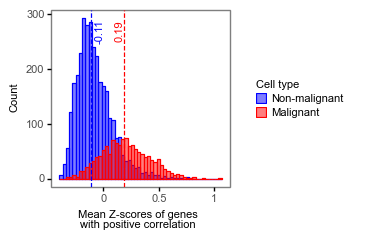

<ggplot: (8754898013287)>

In [11]:
data_zscore_mean_high_corr = pd.read_csv('../data/single-cell/melanoma/data_zcore_mean_high_corr_genes.csv', 
                                    index_col=0)

data_zscore_mean = data_zscore_mean_high_corr.rename({'mean_z_high':'Mean Z-score'}, axis=1)
data_zscore_mean['Cell type'] = (data_zscore_mean['Cell type']
                                 .astype('category')
                                 .cat.reorder_categories(['Malignant',
                                                          'Non-malignant',
                                                          ][::-1]))

mal = data_zscore_mean_high_corr.loc[data_zscore_mean_high_corr['Cell type'] == 'Malignant', 'mean_z_high']
non_mal = data_zscore_mean_high_corr.loc[data_zscore_mean_high_corr['Cell type'] == 'Non-malignant', 'mean_z_high']
p_value_hcorr = mannwhitneyu(mal, non_mal)[1]
# 3.499311996382273e-297

mal_median = mal.median()
# 0.1871607042610495
non_mal_median = non_mal.median()
# -0.10640038785891125

p = (ggplot(data_zscore_mean, aes(x='Mean Z-score', fill='Cell type', color='Cell type',
                                 )) 
     + geom_histogram(position='identity', alpha=0.5, bins=50)
     + geom_vline(xintercept=mal_median, color='red', linetype='dashed')
     + geom_vline(xintercept=non_mal_median, color='blue', linetype='dashed')
     + annotate("text", x=mal_median, label=np.round(mal_median, 2),
             y = 270, angle = 90, ha='right', color='red', size=8)
     + annotate("text", x=non_mal_median+0.03, label=np.round(non_mal_median, 2),
             y = 270, angle = 90, ha='left', color='blue', size=8)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=8),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
        figure_size=(2.3, 2.3))
     + labs(
       x='Mean Z-scores of genes\nwith positive correlation', 
       y='Count', 
       fill='Cell type',
          )
     + scale_color_manual(values=['blue', 'red'])
     + scale_fill_manual(values=['blue', 'red'])
    )
# p.save('../plots/main/6b_pos.pdf')
p

#### Hist of negatively correlated genes

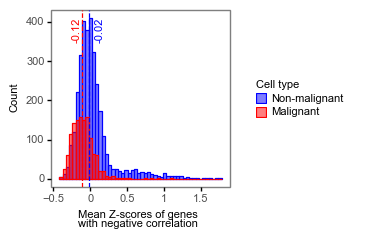

<ggplot: (8754888482283)>

In [13]:
data_zscore_mean_low_corr = pd.read_csv('../data/single-cell/melanoma/data_zcore_mean_low_corr_genes.csv', 
                                    index_col=0)

data_zscore_mean = data_zscore_mean_low_corr.rename({'mean_z_low':'Mean Z-score'}, axis=1)
data_zscore_mean['Cell type'] = (data_zscore_mean['Cell type']
                                 .astype('category')
                                 .cat.reorder_categories(['Malignant',
                                                          'Non-malignant',
                                                          ][::-1]))

mal = data_zscore_mean_low_corr.loc[data_zscore_mean_low_corr['Cell type'] == 'Malignant', 'mean_z_low']
non_mal = data_zscore_mean_low_corr.loc[data_zscore_mean_low_corr['Cell type'] == 'Non-malignant', 'mean_z_low']
p_value_lcorr = mannwhitneyu(mal, non_mal)[1]
# 1.0646316356246993e-98

mal_median = mal.median()
# -0.1164779177387564
non_mal_median = non_mal.median()
# -0.01684096034948905

p = (ggplot(data_zscore_mean, aes(x='Mean Z-score', fill='Cell type', color='Cell type',
                                 )) 
     + geom_histogram(position='identity', alpha=0.5, bins=50)
     + geom_vline(xintercept=mal_median, color='red', linetype='dashed')
     + geom_vline(xintercept=non_mal_median, color='blue', linetype='dashed')
     + annotate("text", x=mal_median, label=np.round(mal_median, 2),
             y = 380, angle = 90, ha='right', color='red', size=8)
     + annotate("text", x=non_mal_median+0.07, label=np.round(non_mal_median, 2),
             y = 380, angle = 90, ha='left', color='blue', size=8)
     + theme_bw()
     + theme(panel_grid=element_blank(),
        legend_key=element_blank(),
        text=element_text(size=8),
        axis_title=element_text(size=8),
        axis_text=element_text(size=8),
        legend_text=element_text(size=8),
        legend_title=element_text(size=8),
        legend_key_size=8,
        figure_size=(2.3, 2.3))
     + labs(
       x='Mean Z-scores of genes\nwith negative correlation', 
       y='Count', 
       fill='Cell type',
          )
     + scale_color_manual(values=['blue', 'red'])
     + scale_fill_manual(values=['blue', 'red'])
    )
# p.save('../plots/main/6b_neg.pdf')
p